In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Set the path to the directory containing kaggle.json
kaggle_config_dir = '/content/drive/MyDrive/kaggle.json'

# Set the KAGGLE_CONFIG_DIR environment variable
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir

# Move the uploaded kaggle.json file to the specified directory
!mv kaggle.json $kaggle_config_dir

# Verify the contents of the directory
!ls $kaggle_config_dir

# Install the Kaggle Python package
!pip install kaggle

# Set appropriate permissions to the kaggle.json file
!chmod 600 $kaggle_config_dir/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
/content/drive/MyDrive/kaggle.json
chmod: cannot access '/content/drive/MyDrive/kaggle.json/kaggle.json': Not a directory


In [ ]:
!kaggle datasets download -d subhajournal/phishingemails

Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
 50% 9.00M/18.0M [00:00<00:00, 21.5MB/s]
100% 18.0M/18.0M [00:00<00:00, 43.8MB/s]


# Dataset Loading and Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io
from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping
from typing import List, Optional
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
import zipfile
# Specify the path to your ZIP file
zip_file_path = '/content/phishingemails.zip'

# Specify the directory where you want to extract the contents
extracted_dir = '/content/extracted/'

# Create the target directory if it doesn't exist
!mkdir -p $extracted_dir

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List the contents of the extracted directory
!ls $extracted_dir


Phishing_Email.csv


In [ ]:
df= pd.read_csv("/content/extracted/Phishing_Email.csv")
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


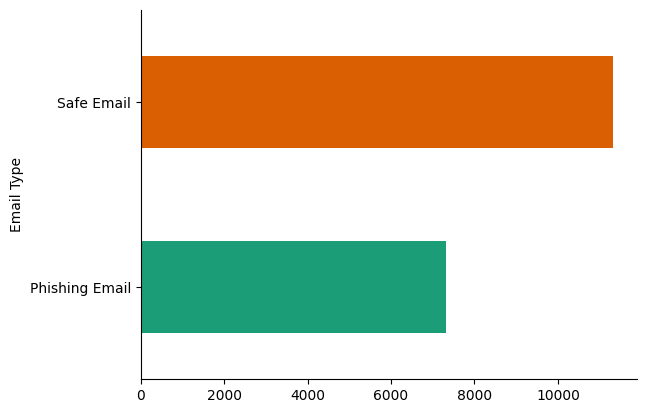

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Email Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.isna().sum()
df = df.dropna()
print(df.isna().sum())

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64


In [ ]:
Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [ ]:
Safe_Email.shape,Phishing_Email.shape
Data= pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
Data.head()

,Unnamed: 0,Email Text,Email Type
0,18622,good looking guy hi vince . look at this guy (...,Safe Email
1,12521,re : 5 . 1462 comparative method two quick off...,Safe Email
2,4121,http://media.guardian.co.uk/broadcast/comment/...,Safe Email
3,17295,re : bob hall / leslie reeves i ' m happy to t...,Safe Email
4,14729,re : 3 . 399 human subjects when our graduate ...,Safe Email


In [ ]:
print(Data.columns)

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

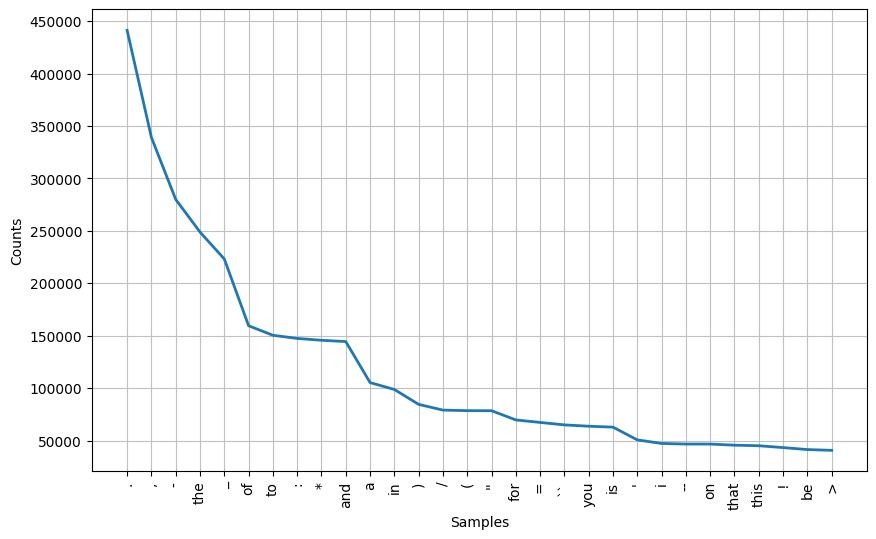

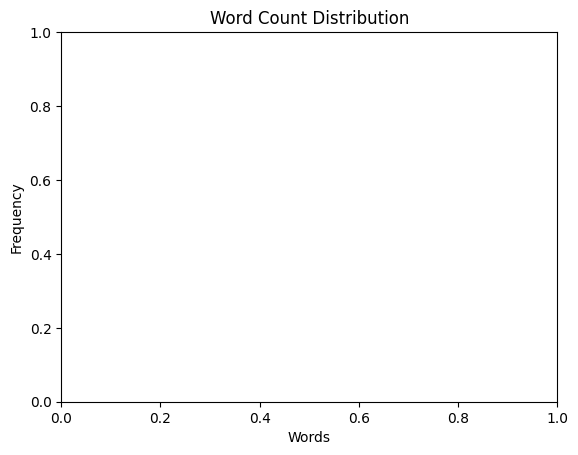

In [ ]:
all_words = [word.lower() for email in Data['Email Text'] for word in word_tokenize(email)]
word_freq = FreqDist(all_words)

# Plot the word count distribution
plt.figure(figsize=(10, 6))
word_freq.plot(30, cumulative=False)
plt.title('Word Count Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

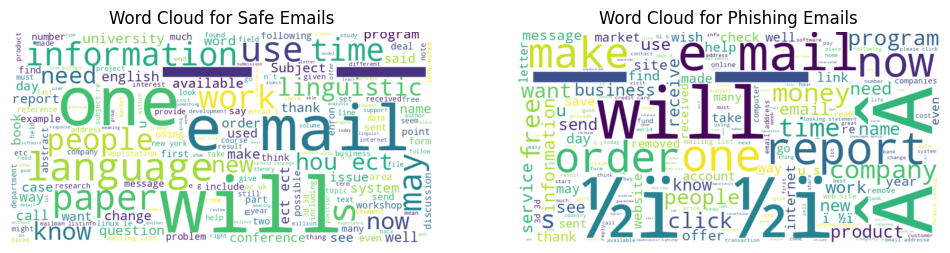

In [ ]:
from wordcloud import WordCloud

# Word Clouds for Safe and Phishing Emails
safe_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(Data[Data['Email Type'] == 'Safe Email']['Email Text']))
phishing_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(Data[Data['Email Type'] == 'Phishing Email']['Email Text']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(safe_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Safe Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Phishing Emails')
plt.axis('off')

plt.show()


# Experimentation

In [ ]:
X = Data["Email Text"].values
y = Data["Email Type"].values


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

###### Model => DecisionTreeClassifier
Test Accuracy : 89.26618%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.89      0.90      0.89      2198
    Safe Email       0.90      0.88      0.89      2190

      accuracy                           0.89      4388
     macro avg       0.89      0.89      0.89      4388
  weighted avg       0.89      0.89      0.89      4388

Confusion Matrix


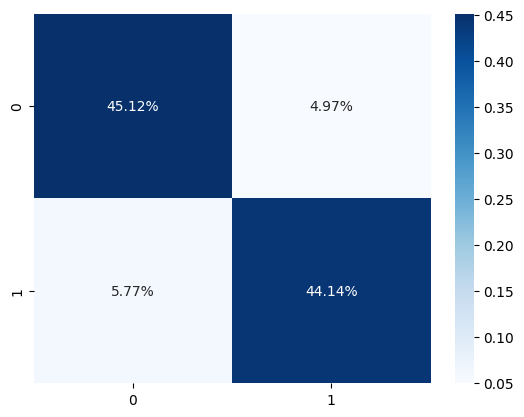

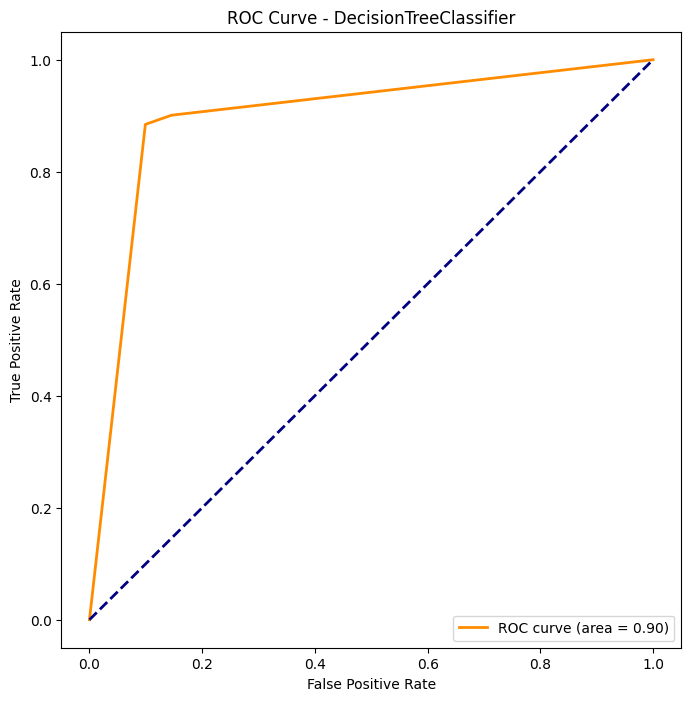

###### Model => SVC
Test Accuracy : 97.74385%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.97      0.99      0.98      2198
    Safe Email       0.99      0.96      0.98      2190

      accuracy                           0.98      4388
     macro avg       0.98      0.98      0.98      4388
  weighted avg       0.98      0.98      0.98      4388

Confusion Matrix


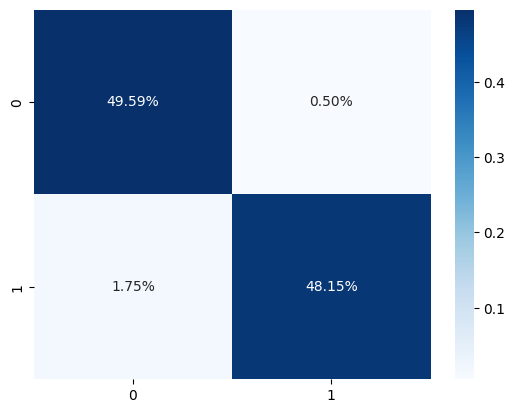

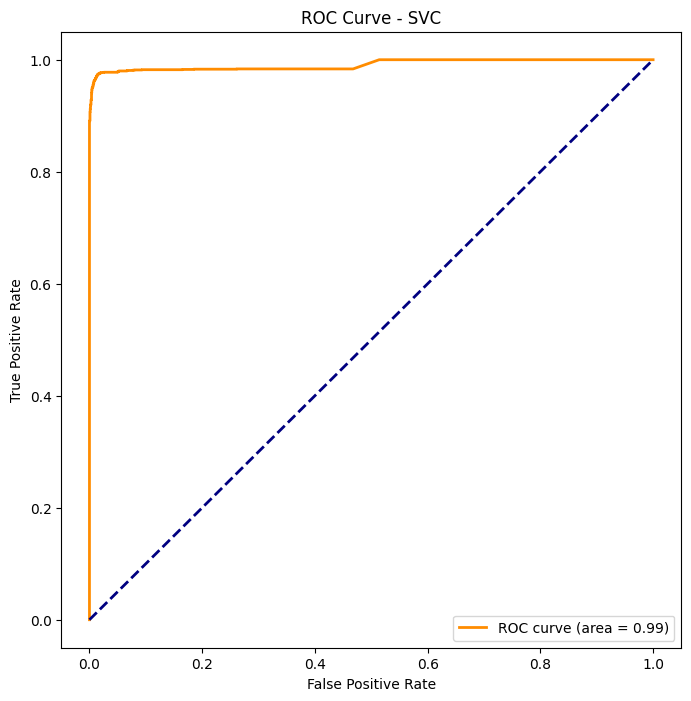

###### Model => MLPClassifier
Test Accuracy : 98.26800%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.97      0.99      0.98      2198
    Safe Email       0.99      0.97      0.98      2190

      accuracy                           0.98      4388
     macro avg       0.98      0.98      0.98      4388
  weighted avg       0.98      0.98      0.98      4388

Confusion Matrix


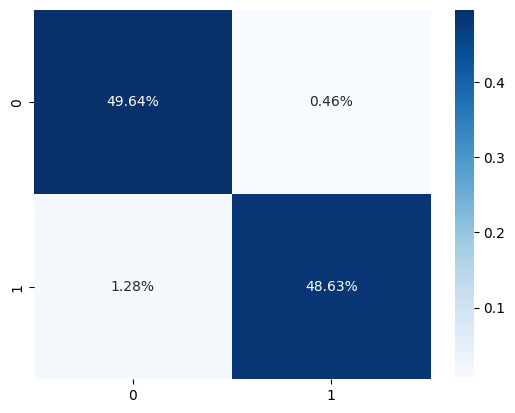

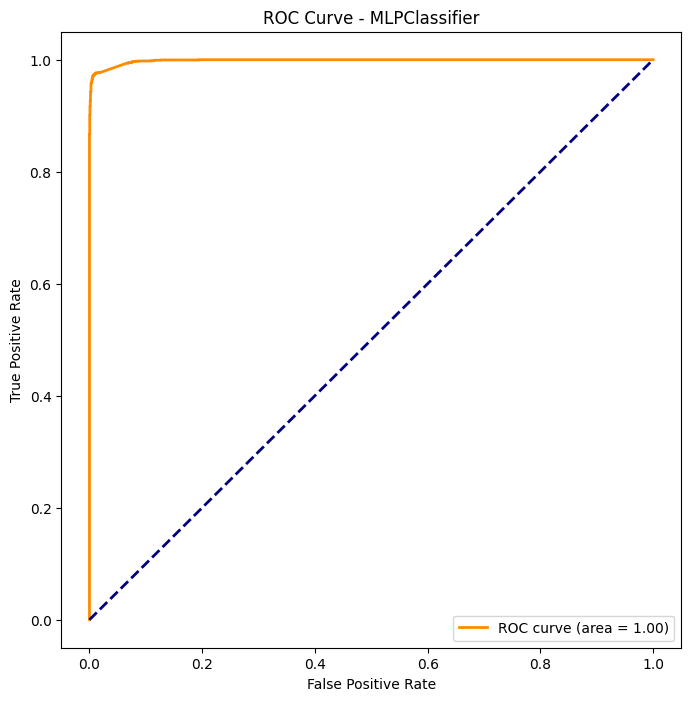

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = [
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]), {}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SVC(probability=True))]), {}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", MLPClassifier())]), {})
]

accuracy_test = []
model_names = []

for pipeline, params in models:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Model => {model_name}')

    pipeline.fit(X_train, y_train)

    # Prediction and Accuracy
    pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)

    print(f'Test Accuracy : {acc*100:.5f}%')

    # Classification Report
    print('Classification Report')
    print(classification_report(y_test, pred))

    # Confusion Matrix
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()

    # ROC Curve
    if hasattr(pipeline.steps[-1][1], 'decision_function'):
        y_score = pipeline.decision_function(X_test)
    else:
        y_score = pipeline.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
import joblib

# Assuming you have already trained your MLPClassifier (mlp_clf)

# Save the trained model to a file
model_filename = 'mlp_classifier_model.pkl'
joblib.dump(MLPClassifier(), model_filename)

print(f'MLPClassifier saved to {model_filename}')


MLPClassifier saved to mlp_classifier_model.pkl


In [ ]:
print(pipeline)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MLPClassifier())])


In [ ]:
import joblib  # for scikit-learn versions prior to 0.24
# If you are using scikit-learn version 0.24 or newer, use:
# from joblib import dump

# List of pre-trained models
pretrained_models = [
    ('DecisionTreeClassifier_model.joblib', DecisionTreeClassifier()),
    ('SVC_model.joblib', SVC(probability=True)),
    ('MLPClassifier_model.joblib', MLPClassifier())
]

# Save pre-trained models
for model_filename, model_instance in pretrained_models:
    joblib.dump(model_instance, model_filename)  # or use dump(model_instance, model_filename)
    print(f'Model saved as {model_filename}')


Model saved as DecisionTreeClassifier_model.joblib
Model saved as SVC_model.joblib
Model saved as MLPClassifier_model.joblib
